# Testbench for `conv2d_w1()`

In [ ]:
#
# Copyright (C) 2024, Advanced Micro Devices, Inc. All rights reserved.
# SPDX-License-Identifier: MIT
#
# Author: Mark Rollins

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
import numpy as np
import os.path

2024-10-03 11:13:28.899639: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 11:13:28.903604: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 11:13:28.912441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 11:13:28.924431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 11:13:28.928140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 11:13:28.940970: I tensorflow/core/platform/cpu_feature_gu

## Layer Definition

In [2]:
inputs = keras.Input(shape=(28,28,1),name="input_layer")
outputs = layers.Conv2D(filters=16,kernel_size=3,activation="relu",name="conv2d_w1")(inputs)
model = keras.Model(inputs=inputs,outputs=outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
w_taps = np.loadtxt('taps_trained.txt')
w_taps = (w_taps.astype("bfloat16")).astype("float32")
w_bias = np.loadtxt('bias_trained.txt')
w_bias = (w_bias.astype("bfloat16")).astype("float32")
w_taps = np.reshape(w_taps,(3,3,1,16))
model.set_weights((w_taps,w_bias))

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_w1 (Conv2D)              │ (None, 26, 26, 16)     │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160 (640.00 B)

 Trainable params: 160 (640.00 B)

 Non-trainable params: 0 (0.00 B)

## Load NMIST Images

In [4]:
# Set batch size and # of batches
BS=1
NB_trn = 4
NB_tst = 4
# Load MNIST database:
(trn_images,trn_labels), (tst_images,tst_labels) = mnist.load_data()
tst_images = tst_images.reshape((10000,28,28,1))
tst_images = tst_images[:NB_tst*BS,:,:,:]
# Extract usable data:
tst_labels = tst_labels[:NB_tst*BS]
tst_images = tst_images.astype("float32") / 255
tst_images = (tst_images.astype("bfloat16")).astype("float32")

## Compute Golden Outputs

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


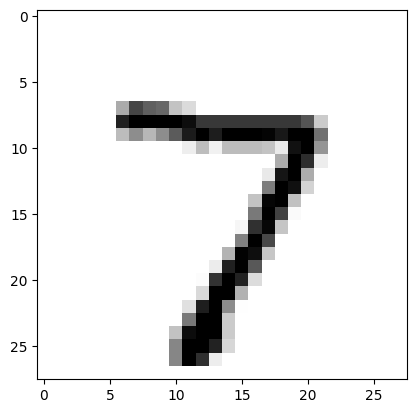

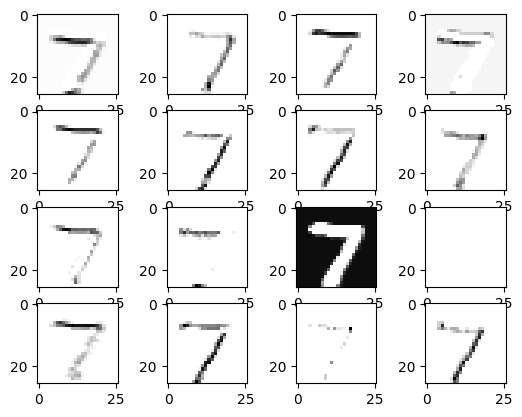

In [5]:
predict = model.predict(tst_images,batch_size=1)
predict = (predict.astype("bfloat16")).astype("float32")
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(tst_images[0],cmap=plt.cm.binary)
fig,ax = plt.subplots(nrows=4,ncols=4)
for ii in range(4):
    for jj in range(4):
        ax[ii,jj].imshow(predict[0,:,:,4*ii+jj],cmap=plt.cm.binary)

## Store Layer Inputs

In [6]:
np.savetxt('data/ifm_i.txt',np.reshape(tst_images,(-1,4)),fmt='%f %f %f %f')
ifm_i = np.reshape(tst_images,(-1,1))

## Store Layer Outputs

In [7]:
np.savetxt('data/ofm_i.txt',np.reshape(predict,(-1,4)),fmt='%f %f %f %f')
ofm_o = np.reshape(predict,(-1,1))

## Store Taps & Bias in 3x3 Column-Major Order to PLIO

In [8]:
tmp = np.concatenate((np.reshape(w_taps,(-1,1)),np.reshape(w_bias,(-1,1))),axis=0)
np.savetxt('data/wts_i.txt',np.reshape(tmp,(-1,4)),fmt='%f %f %f %f')
wts_i = np.reshape(tmp,(-1,1))

## Run Vitis Functional Simulation

In [ ]:
import os
import vfs
conv2d_w1_graph = vfs.aieGraph(
    input_file='conv2d_w1_app.cpp',
    part="xcve2802-vsvh1760-2MP-e-S",
    include_paths=['./','../mnist','../wts_init'])
act_o = conv2d_w1_graph.run(vfs.array(ifm_i[:,0],vfs.bfloat16),vfs.array(wts_i[:,0],vfs.bfloat16))

In [ ]:
act_o = np.array(act_o)
act_o = np.reshape(act_o,(4,26,32,16))
ofm_o = np.reshape(ofm_o,(4,26,26,16))
act_o = act_o[:,:,:26,:]   # Remove zero pad
err = np.reshape(ofm_o-act_o,(-1,1))
tmp = np.reshape(ofm_o,(-1,1))
lvl = np.max(np.abs(tmp))
lvl_min = -(0.5**8)*lvl*np.ones((len(tmp),1))
lvl_max = +(0.5**8)*lvl*np.ones((len(tmp),1))
tt = np.arange(0,len(tmp))
plt.plot(tt,err,tt,lvl_min,tt,lvl_max)
plt.title("Pixel Error")
plt.show()

In [ ]:
print("Model    Actual")
fig,ax = plt.subplots(nrows=2,ncols=2)
for ii in range(2):
    ax[ii,0].set(title="Model")
    ax[ii,1].set(title="AIE")
    ax[ii,0].imshow(ofm_o[0,:,:,ii].astype("float32"),cmap=plt.cm.binary)
    ax[ii,1].imshow(act_o[0,:,:,ii].astype("float32"),cmap=plt.cm.binary,)